# Advanced ML. Домашнее задание 1

## Задание 1.

https://ourworldindata.org/coronavirus-source-data

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

Подготовим датасет в соответствии с поставленным условием

In [165]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

In [166]:
df = pd.read_csv("owid-covid-data.csv")

In [167]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [168]:
russian_data = df[df['iso_code'] == 'RUS']
russian_data['date'] = russian_data['date'].astype('datetime64[ns]')

In [169]:
import datetime

In [170]:
start_train = datetime.datetime(year=2020, month=3, day=3)
end_test_sep = end_train + datetime.timedelta(days=142)

In [174]:
russian_data = russian_data[['date', 'total_cases', 'new_cases']].reset_index(drop=True)
russian_data = russian_data[(russian_data['date'] >= start_train) & (russian_data['date'] <= end_test_sep)]
russian_data['day_number'] = russian_data.index
russian_data['new_cases'] = russian_data['new_cases'].replace(0.0, 1.0)

In [175]:
russian_data = russian_data.reset_index(drop=True)

In [176]:
russian_data.head()

,date,total_cases,new_cases,day_number
0,2020-03-03,3.0,1.0,0
1,2020-03-04,3.0,1.0,1
2,2020-03-05,4.0,1.0,2
3,2020-03-06,13.0,9.0,3
4,2020-03-07,13.0,1.0,4


Датасет готов, перейдем к следующему заданию

## Задание 2.

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

In [177]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,6)
legend_fontsize = 16

График, отражающий общее число заболевших

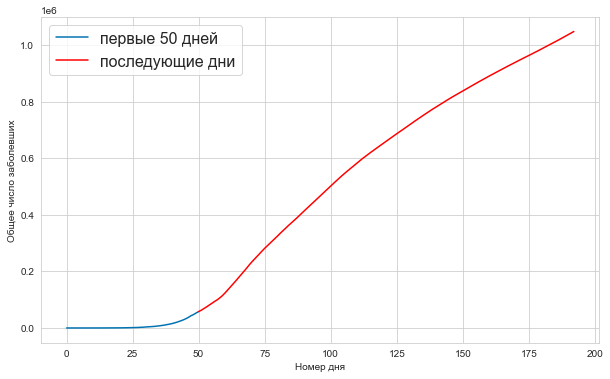

In [178]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

xs_zero = russian_data['day_number'][:51]
ys_zero = russian_data['total_cases'][:51]
xs_one = russian_data['day_number'][50:]
ys_one = russian_data['total_cases'][50:]

ax.plot(xs_zero, ys_zero, label="первые 50 дней")
ax.plot(xs_one, ys_one, c='red',   label="последующие дни")
ax.set_ylabel("Общее число заболевших")
ax.set_xlabel("Номер дня")
ax.legend(fontsize=legend_fontsize)
plt.show()

График, отражающий количество новых заболевших

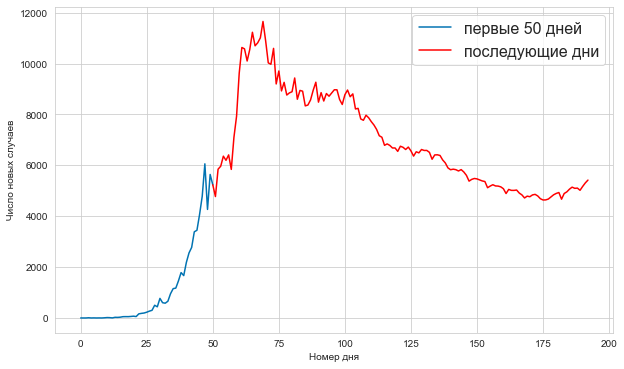

In [179]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

xs_zero = russian_data['day_number'][:51]
ys_zero = russian_data['new_cases'][:51]
xs_one = russian_data['day_number'][50:]
ys_one = russian_data['new_cases'][50:]

ax.plot(xs_zero, ys_zero, label="первые 50 дней")
ax.plot(xs_one, ys_one, c='red', label="последующие дни")
ax.set_ylabel("Число новых случаев")
ax.set_xlabel("Номер дня")
ax.legend(fontsize=legend_fontsize)
plt.show()

### Пункт а)

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

### Решение.

Воспользуемся известным трюком: вместо обучения экспоненты, будем обучать логарифмы от экспоненты:

$$\log{y} \sim w_1 \cdot x + w_0$$

In [181]:
X = russian_data['day_number'][:50].values.reshape(-1, 1)
y = np.log(russian_data[:50].total_cases.values).reshape(-1, 1)

In [182]:
len(X)

50

In [183]:
model = LinearRegression()

In [184]:
model.fit(X, y)

LinearRegression()

Получившиеся коэффициенты обученной модели:

In [185]:
w_1, w_0 = model.coef_[0][0], model.intercept_[0]
print(w_1, w_0)

0.19829091233588567 1.820737148784695


Сделаем предсказания по количеству заболевших в последующие дни

In [186]:
X_test = russian_data[50:].day_number.values.reshape(-1, 1)

In [187]:
preds = model.predict(X_test)

In [188]:
new_preds = []
for element in preds:
    new_preds.append(element[0])

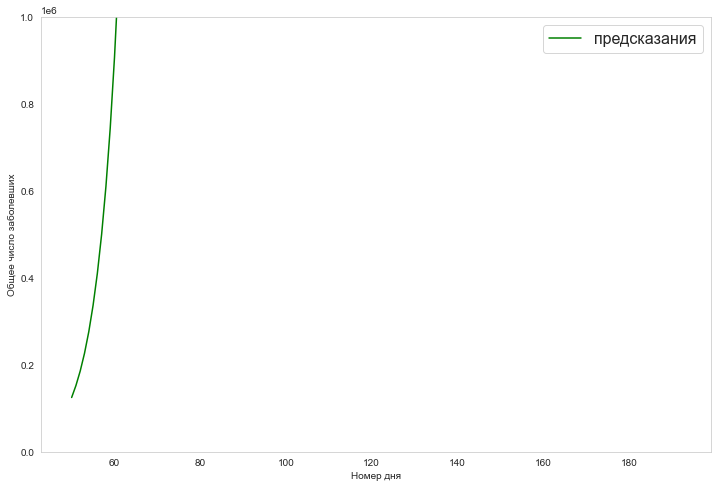

In [189]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1000000])

ax.plot(xs_one, np.exp(new_preds), c='green', label="предсказания")
ax.set_ylabel("Общее число заболевших")
ax.set_xlabel("Номер дня")
plt.grid()
ax.legend(fontsize=legend_fontsize)
plt.show()

Как и ожидалось, по прогнозам улетаем в космос :(

### Пункт b)

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

### Решение.

Дисперсию шума оценим как стандартное отклонение между данными и предсказанием:
$$\sigma^2 = \frac{1}{n} \sum_{i} (y_i - w_0 - w_1 * x_i)^2$$

In [190]:
sigma_noise = np.sqrt(((y - w_0 - w_1 * X) ** 2).sum() / len(y))

Реализуем функцию bayesian_update

In [191]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) +
                     (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [192]:
my_x = np.column_stack([np.ones(xs_zero.shape[0] - 1), X])

In [193]:
mu, sigma = bayesian_update(np.zeros(2), np.eye(2), my_x, np.log(russian_data['total_cases'][:50]).values, sigma_noise)

Выведем на экран получившиеся параметры:

In [194]:
print(mu)

[1.80373124 0.19880564]


In [195]:
print(sigma)

[[ 9.37104759e-03 -2.83970283e-04]
 [-2.83970283e-04  1.16188656e-05]]


### Пункт c)

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

### Решение.

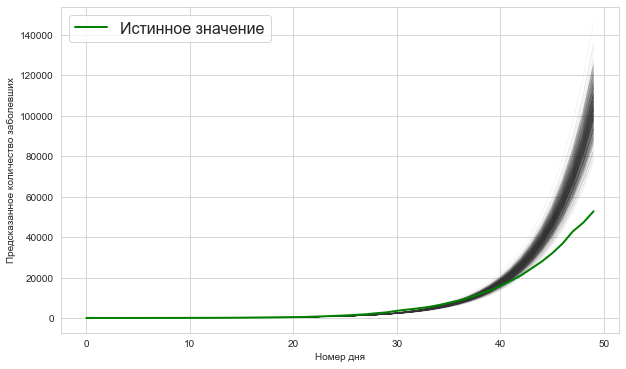

In [196]:
n = 500
w = np.random.multivariate_normal(mu, sigma, n)
plt.figure(figsize=figsize)

for i in range(n):
    plt.plot(russian_data["day_number"][:50], np.exp(my_x.dot(w[i])),
            color="0.2", linewidth=.05)
plt.plot(russian_data["day_number"][:50], russian_data["total_cases"][:50],
         label="Истинное значение", color="g", linewidth=2)

plt.grid(True)
plt.xlabel("Номер дня")
plt.ylabel("Предсказанное количество заболевших")
plt.legend(fontsize=legend_fontsize)

In [197]:
xc = pd.Series([59, 90, 182]) # номера дней на первое мая, июня и сентября
xc_m = np.column_stack([np.ones(len(xc)), xc])
prediction_c = np.exp(w.dot(xc_m.T))

Text(0.5, 1.0, 'Предсказание на первое сентября')

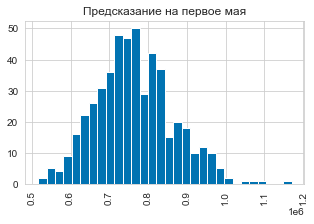

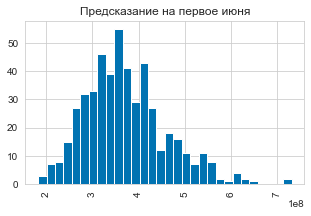

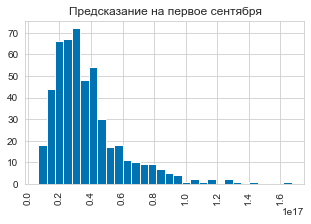

In [198]:
figsize1 = (5,3)

plt.figure(figsize=figsize1)
plt.hist(prediction_c[:, 0], bins=30)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Предсказание на первое мая")

plt.figure(figsize=figsize1)
plt.hist(prediction_c[:, 1], bins=30)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Предсказание на первое июня")

plt.figure(figsize=figsize1)
plt.hist(prediction_c[:, 2], bins=30)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Предсказание на первое сентября")

Выведем медианные значения предсказаний по общему количеству заболевших на 1 мая, 1 июня и 1 сентября, соответственно:

In [199]:
print(round(np.median(prediction_c[:, 0])))
print(round(np.median(prediction_c[:, 1])))
print(round(np.median(prediction_c[:, 2])))

757476.0
359512708.0
3.1821387189852516e+16


Предсказания действительно очень грустные

## Задание 3.

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\Phi(x) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-\frac{t^2}{2}}dt$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от $t$.

### Пункт a)

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

### Решение.

Введем произвольную константу перед интегралом и внесем в экспоненту произвольную квадратичную функцию от  $t$

$$y(x) = \alpha \int_{-\infty}^{x} e^{at^2 + bt + c}dt = \int_{-\infty}^{x} e^{at^2 + bt + d}dt$$

Рассмотрим, идущих подряд, два дня. В нашей модели:

$$y_{i + 1} - y_i = e^{at^2 + bt + d}$$

Воспользуемся той же идеей, что и в пункте 2: прологарифмируем обе части

$$log(y_{i + 1} - y_i) = at^2 + bt + d$$

Таким образом для обучения переменной слева в качестве признаков можно взять номер дня и квадрат от номера дня.

### Пункт b)

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

### Решение.

Поступим аналогично с пунктом 2) только теперь у нас добавился новый признак - квадрат номера дня

In [200]:
X_new = np.column_stack([X, X ** 2])
y_new = np.log(russian_data[:50].total_cases.values).reshape(-1, 1)
model.fit(X_new, y_new)

LinearRegression()

In [201]:
X_new_test = np.column_stack([X_test, X_test ** 2])

In [202]:
preds_2 = model.predict(X_new_test)
new_preds_2 = []
for element in preds_2:
    new_preds_2.append(element[0])

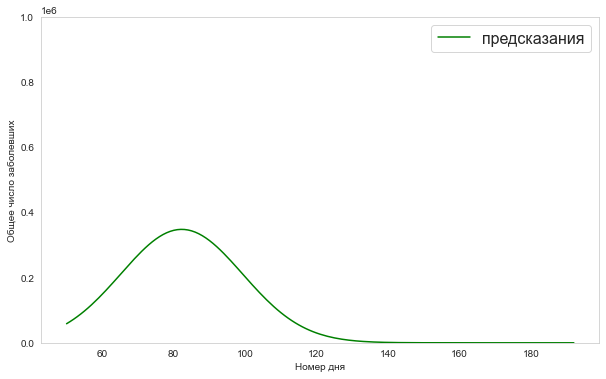

In [203]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1000000])

ax.plot(xs_one, np.exp(new_preds_2), c='green', label="предсказания")
ax.set_ylabel("Общее число заболевших")
ax.set_xlabel("Номер дня")
plt.grid()
ax.legend(fontsize=legend_fontsize)
plt.show()

Найдем параметры распределения:

In [204]:
my_new_x = np.column_stack([np.ones(xs_zero.shape[0] - 1), X_new])
mu_new, sigma_new = bayesian_update(np.zeros(3), np.eye(3), my_new_x, y_new, sigma_noise)

In [211]:
my_new_x.shape

(50, 3)

In [205]:
print(mu_new[:, 0])

[ 1.12507647  0.2842475  -0.0017477 ]


In [206]:
print(sigma_new)

[[ 1.98595755e-02 -1.60446389e-03  2.70105244e-05]
 [-1.60446389e-03  1.77867492e-04 -3.40059397e-06]
 [ 2.70105244e-05 -3.40059397e-06  6.95587060e-08]]


### Пункт c)

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

### Решение.

Поступим аналогично с пунктом 2) только теперь у нас добавился новый признак - квадрат номера дня

In [219]:
xmn = pd.Series([59, 90, 182])
xc_mn = np.column_stack([np.ones(len(xmn)), xmn, xmn ** 2])
prediction_mn = np.exp(w.dot(xc_mn.T)).cumsum(1)

In [ ]:
xcn = pd.Series([59, 90, 182]) # номера дней на первое мая, июня и сентября
xc_mn = np.column_stack([np.ones(len(xcn)), xcn])
prediction_mn = np.exp(w.dot(xc_mn.T))

Text(0.5, 1.0, 'Предсказание на первое сентября')

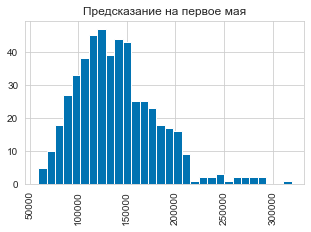

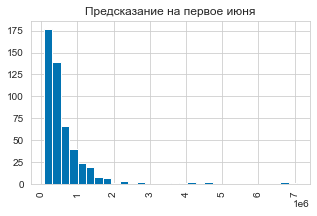

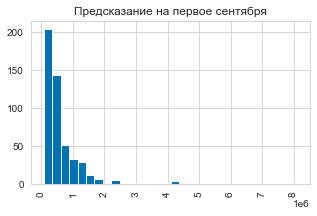

In [220]:
figsize1 = (5,3)

plt.figure(figsize=figsize1)
plt.hist(prediction_mn[:, 0], bins=30)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Предсказание на первое мая")

plt.figure(figsize=figsize1)
plt.hist(prediction_mn[:, 1], bins=30)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Предсказание на первое июня")

plt.figure(figsize=figsize1)
plt.hist(prediction_mn[:, 2], bins=30)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Предсказание на первое сентября")

Выведем медианные значения предсказаний по общему количеству заболевших на 1 мая, 1 июня и 1 сентября, соответственно:

In [221]:
print(round(np.median(prediction_mn[:, 0])))
print(round(np.median(prediction_mn[:, 1])))
print(round(np.median(prediction_mn[:, 2])))

134456.0
405178.0
405178.0


Выведем 10-процентиль предсказаний по общему количеству заболевших на 1 мая, 1 июня и 1 сентября, соответственно:

In [226]:
print(round(np.quantile(prediction_mn[:, 0], 0.1)))
print(round(np.quantile(prediction_mn[:, 1], 0.1)))
print(round(np.quantile(prediction_mn[:, 2], 0.1)))

91106.0
163580.0
163580.0


Выведем 10-процентиль предсказаний по общему количеству заболевших на 1 мая, 1 июня и 1 сентября, соответственно:

In [227]:
print(round(np.quantile(prediction_mn[:, 0], 0.9)))
print(round(np.quantile(prediction_mn[:, 1], 0.9)))
print(round(np.quantile(prediction_mn[:, 2], 0.9)))

193656.0
1267848.0
1267866.0
